# PlaygroundML
---
# 5. Gaussian Processes

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from gaussian_process import GaussianProcess, rbf_kernel, linear_kernel

# Set latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 5.1 Gaussian Process Regression

### 5.1.1 Toy Data

First, we wish to generate some *toy data* to use for Gaussian Process Regression. We will use a sine wave with some Gaussian noise added to it. Below we generate the data and plot it.

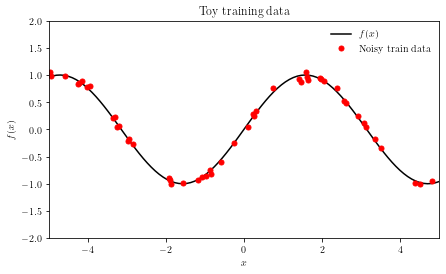

In [3]:
# Define synthetic train data
true_x = np.linspace(-5, 5, 100)
true_f = lambda x: np.sin(x)
noisy_f = lambda x: true_f(x) + np.random.normal(0, 0.05, x.shape[0])

n_trainpoints = 50
x_train = np.random.uniform(-5, 5, n_trainpoints)
y_train = noisy_f(x_train)

plt.figure(figsize=(7, 4))
plt.plot(true_x, true_f(true_x), 'k', label='$f(x)$')
plt.plot(x_train, y_train, color='r', marker='o', markersize=5, linestyle='None', label='Noisy train data')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.legend(frameon=False)
plt.title('Toy training data')
plt.show()

### 5.1.2 Sampling from the GP Prior

A covariance kernel $K: \mathcal{X}\times\mathcal{X}\to\mathbb{R}$ is a function such that for two input datapoints $\mathbf{x}$, $\mathbf{x}'\in\mathcal{X}$ with corresponding outputs $y$ and $y'$:

$$
    K(\mathbf{x},\mathbf{x}') = \text{Cov}[y,y']
$$

A covariance kernel $K(\mathbf{x},\mathbf{x}')$ and a mean function $m(\mathbf{x})$ defined on some domain $\mathcal{X}$ defines a *Gaussian process (GP)*. If $f(\mathbf{x})$ is a random variable `indexed' by $\mathbf{x}$, a draw from the whole GP defines a random function $f: \mathcal{X}\to\mathbb{R}$ such that

$$
    f(\cdot)\sim\mathcal{GP}(m(\cdot),K(\cdot,\cdot))
$$

For a set of input points $\mathbf{X} = (\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)})\in\mathbb{R}^{D\times N}$, the joint distribution of function evaluations $\mathbf{f} = (f(\mathbf{x}^{(1)}),\ldots,f(\mathbf{x}^{(N)}))^\top$ is

$$
    \mathbf{f} | \mathbf{X}, K \sim \mathcal{N}(\mathbf{m},\mathbf{K})
$$

where $K_{ij} = K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$ and $m_i = m(\mathbf{x}^{(i)})$. In this example, we take the mean function to be zero: $\mathbf{m} = \mathbf{0}$. Below we take 5 samples from the GP prior and plot the results.

(500, 500)


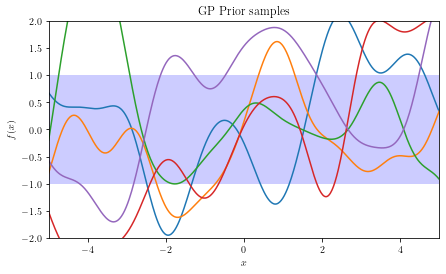

In [4]:
# Define the kernel and mean functions
sigma = 0.75
kernel = rbf_kernel(sigma)
mu = lambda x: np.zeros(x.shape)
noise = 0.05

# Define the Gaussian process
x_test = np.linspace(-5, 5, 500)
mu_x = mu(x_test)
gp = GaussianProcess(mu, kernel, noise)
f_prior, std = gp.get_prior(x_test, n_samples=5)

# Plot prior samples
plt.figure(figsize=(7, 4))
plt.plot(x_test, f_prior)
plt.fill_between(x_test, mu_x - std, mu_x + std, color='b', alpha=0.2, edgecolor=None)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.title('GP Prior samples')
plt.show()

### 5.1.3 Sampling from the GP Posterior

In Gaussian Process Regression (GPR), we wish to find the predictive (posterior) mean and covariance on a set of test inputs, given the training data. Consider a set of training inputs $\mathbf{X} = (\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)})$ that have corresponding noisy observations $\mathbf{y} = (f(\mathbf{x}^{(1)})+\epsilon,\ldots,f(\mathbf{x}^{(N)})+\epsilon)^\top$, where $\epsilon\sim\mathcal{N}(0,\sigma^2_n)$ is i.i.d Gaussian noise. Suppose we have a set of test inputs $\mathbf{X}_* = (\mathbf{x}_*^{(1)},\ldots,\mathbf{x}_*^{(N)})$, that has a corresponding set of function evaluations, $\mathbf{f}_*$ (that we do not know). Using a zero-mean GP prior, the joint distribution of $\mathbf{y}$ and $\mathbf{f}_*$ is given by

$$
    \begin{bmatrix}
        \mathbf{y} \\
        \mathbf{f}_*
    \end{bmatrix}
    \sim \mathcal{N}\left(
    \begin{bmatrix}
        \mathbf{0} \\
        \mathbf{0}
    \end{bmatrix},
    \begin{bmatrix}
        \mathbf{K} + \sigma_n^2\mathbf{I} & \mathbf{K}_{*} \\
        \mathbf{K}_*^\top & \mathbf{K}_{**}
    \end{bmatrix}
    \right)
$$

where $[\mathbf{K}]_{ij} = K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$, $[\mathbf{K}_*]_{ij} = K(\mathbf{x}^{(i)},\mathbf{x}_*^{(j)})$ and $[\mathbf{K}_{**}]_{ij} = K(\mathbf{x}_*^{(i)},\mathbf{x}_*^{(j)})$. The resulting posterior distribution on the test outputs $\mathbf{f}_*$ *conditioned* on the noisy train outputs, $\mathbf{y}$, and the inputs $\mathbf{X}$ and $\mathbf{X}_*$, is given by
$$
    \mathbf{f}_* | \mathbf{y}, \mathbf{X}, \mathbf{X}_*,  K \sim \mathcal{N}\biggl(\mathbf{K}_{*}^\top\left(\mathbf{K} + \sigma_n^2\right)^{-1}\mathbf{y}\:,\:\mathbf{K}_{**} - \mathbf{K}_{*}^\top\left(\mathbf{K} + \sigma_n^2\right)^{-1}\mathbf{K}_{*}\biggr)
$$
Below, we plot the posterior mean and variance on a series of test inputs, given the training data, along with 5 posterior samples.

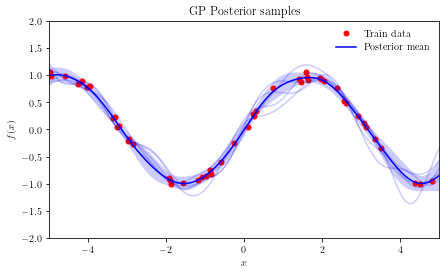

In [5]:
# Plot posterior samples
gp = GaussianProcess(mu, kernel, noise)
mean, Cov = gp.get_posterior(x_train, y_train, x_test)
f_posterior = gp.posterior_sample(x_train, y_train, x_test, n_samples=5)
std = np.sqrt(np.diag(Cov))

plt.figure(figsize=(7, 4))
plt.plot(x_train, y_train, color='r', marker='o', markersize=5, linestyle='None', label='Train data') # Plot train data
plt.plot(x_test, f_posterior, color='b', alpha=0.2) # Plot posterior samples
plt.plot(x_test, mean, color='b', label='Posterior mean') # Plot posterior mean
plt.fill_between(x_test, mean - std, mean + std, color='b', alpha=0.2, edgecolor=None) # Plot posterior mean +/- std
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.legend(frameon=False)
plt.title('GP Posterior samples')
plt.show()

We also give a script below to plot an animation of the GP posterior mean and variance, as each training data point is added sequentially.

MovieWriter imagemagick unavailable; using Pillow instead.


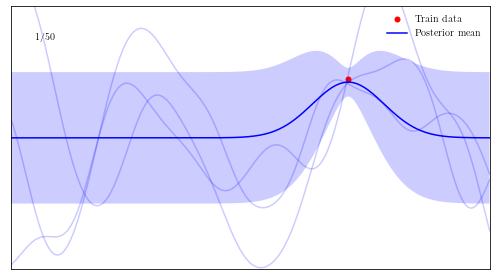

In [6]:
n_posterior_samples = 3

# Plot gif of posterior samples where one point is added at each iteration
def animate(i):
    """Single frame of the gif animation."""
    gp = GaussianProcess(mu, kernel, noise)
    mean, Cov = gp.get_posterior(x_train[:i+1], y_train[:i+1], x_test)
    posterior_samples = np.random.multivariate_normal(mean, Cov, n_posterior_samples)
    std = np.sqrt(np.diag(Cov))

    plt.cla()
    plt.plot(x_train[:i+1], y_train[:i+1], color='r', marker='o', markersize=5, linestyle='None', label='Train data')
    plt.plot(x_test, mean, 'b-', label='Posterior mean')
    plt.fill_between(x_test, mean - std, mean + std, color='b', alpha=0.2, edgecolor=None)
    plt.plot(x_test, posterior_samples.T, 'b-', alpha=0.2)
    plt.text(-4.5, 1.5, f'{i+1}/{n_trainpoints}')
    plt.xlim(-5, 5)
    plt.ylim(-2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False, loc='upper right')
    plt.tight_layout()
    
# Plot gif of posterior samples where one point is added at each iteration
from matplotlib import animation

fig = plt.figure(figsize=(7, 4))
anim = animation.FuncAnimation(fig, animate, frames=n_trainpoints, interval=100)

# Save as gif
anim.save('gp.gif', writer='imagemagick', fps=10, dpi=600)